## Statistisk Analys av Small-diameter-flow Data




I denna lab så analyserar jag datasetet *Small-diameter-flow.csv* och undersöker vilka faktorer som påverkar vätskans flöde (*Flow*). 

**Beskrivning av variabler:**
- **Flow**: Vätskans flödeshastighet (beroende variabel, y).
- **Kinematic**: Möjligen "kinematisk viskositet" (vätskans motstånd mot flöde under gravitation, dvs hur lätt den flödar).
- **Geometric**: En geometrisk egenskap hos röret, t.ex. diameter eller form.
- **Inertial**: Tröghet associerad med vätskans rörelse (påverkar flödet).
- **Observer**: Identifierar vilken forskare som samlade in datan (vilket vi längre fram kommer se är ej relevant för regression).

Jag började med att skapa mig en bild utav datan genom att läsa av de första fem raderna. 

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data_path = "./data/Small-diameter-flow.csv"
data = pd.read_csv(data_path, index_col=0)

print(data.head())


        Flow  Kinematic  Geometric   Inertial  Observer
0 -17.047687  -0.584344  -6.896327 -14.323560       0.0
1 -17.043179  -0.584344  -6.896327 -14.323560       0.0
2 -17.043179  -0.584344  -6.896327 -14.323560       0.0
3 -11.182193   1.242506  -5.069476 -11.583284       0.0
4 -11.184430   1.242506  -5.069476 -11.583284       0.0


Därefter så ville jag få datan visualiserad så att jag kunde se ifall jag såg något direkt samband mellan de olika variablerna. 

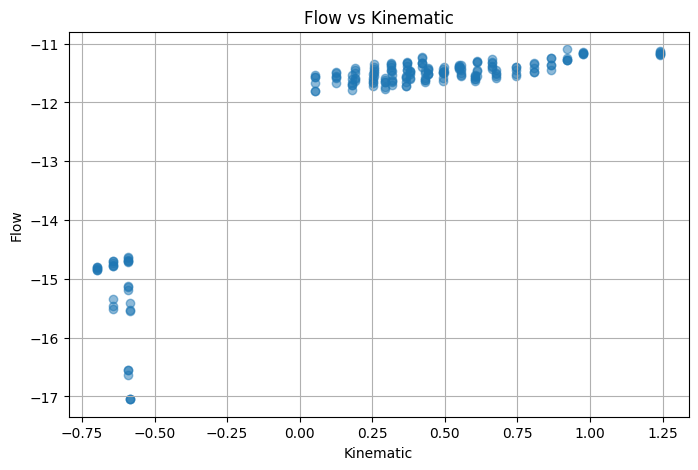

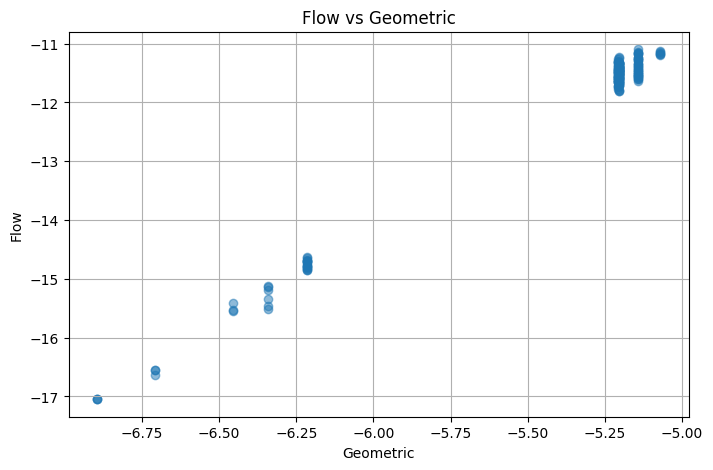

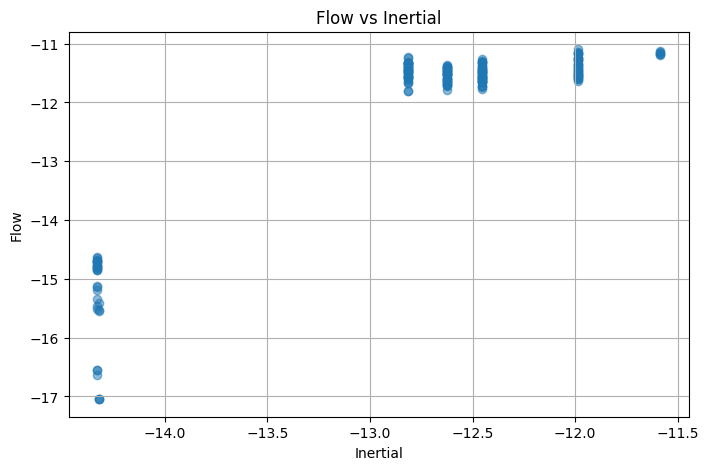

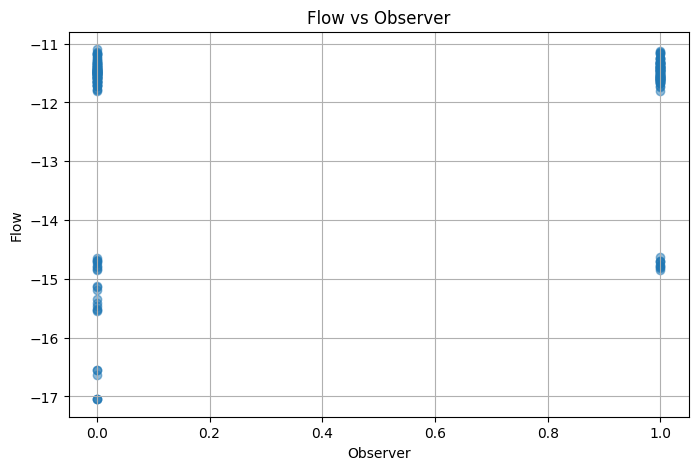

In [14]:
columns = ["Kinematic", "Geometric", "Inertial", "Observer"]

highest_flow = data["Flow"].max()
lowest_flow = data["Flow"].min()

for column in columns:  
    plt.figure(figsize=(8, 5))
    plt.scatter(data[column], data["Flow"], alpha=0.5)
    plt.title(f'Flow vs {column}')
    plt.xlabel(column)
    plt.ylabel('Flow')
    plt.grid(True)
    plt.show()


Det första jag noterade var att värdet _*Flow*_ har ett rätt tydligt gap mellan ca -11.8 och -14.5 
Jag la även märke till något jag förväntade mig - att Observer inte skulle visa något utöver att mätningarna skiljer sig lite, och då att "Observer 0" noterade en del lägre värden än "Observer 1".

Jag ville sedan se korrelationen emellan *_Flow_* och de olika kategorierna.

_*Geometric*_ och _*Inertial*_ verkar ha en extra stark korrelation med _*Flow*_, medan _*Kinematic*_har en svagare korrelation. 

_*Observer*_ verkar dock däremot knappt ha någon korrelation alls med _*Flow*_.

In [15]:
correlation = data[["Flow"] + columns].corr()
print("Korrelation mellan Flow och andra kolumner:")
print(correlation["Flow"])

Korrelation mellan Flow och andra kolumner:
Flow         1.000000
Kinematic    0.863403
Geometric    0.995794
Inertial     0.903310
Observer     0.181490
Name: Flow, dtype: float64


### LinearRegression-klassen

Trots att det var knepigt att skapa min egna LinearRegression-class så var det kul att få se resultaten efteråt. 

Jag presenterar dem genom att låta dem printas ut, och jag hoppas att de är tydliga nog.  

In [16]:
from linear_regression import LinearRegression

X = data.drop(columns=['Flow'])

y = data['Flow'] 

column_names = data.columns[1:] 

model = LinearRegression()
model.fit(X.values, y.values)  # Här använder jag  ".values" för att omvandla till numpy-arrayer så att datan fungarar med min LinearRegression-klass.

print("Number of features: ", model.number_of_features)
print("Sample size: ", model.sample_size)
print("Variance: ", model.variance(X, y))
print("Standard deviation: ", model.standard_deviation(X, y))

f_stat, p_value = model.significance(X, y)

print(f"F-statistik: {f_stat}")
print(f"P-värde för regressionen: {p_value}")
print("R2(Regression relevance): ", model.r_squared(X, y))


t_values, p_values = model.individual_significance(X, y)

print("T-värden för koefficienterna:", [f"{t}" for t in t_values])
print("P-värden för koefficienterna::", [f"{p}" for p in p_values])



Number of features:  4
Sample size:  198
Variance:  0.00627229253835665
Standard deviation:  0.07919780639864119
F-statistik: 16897.077024462826
P-värde för regressionen: 2.197604317692198e-244
R2(Regression relevance):  0.9971526073276518
T-värden för koefficienterna: ['71.41494853947125', '116.42755135045535', '-56.78324847537664']
P-värden för koefficienterna:: ['9.657765796824224e-141', '9.476786740965705e-181', '2.1207639573383535e-122']


In [17]:
X = np.array(X, dtype=float)
y = np.array(y, dtype=float)


column_names = list(data.columns[1:])  # Hämtar feature-namn från DataFrame för mer tydlighet i outputen.

correlation_matrix = model.pearson_correlation_matrix(X, column_names)

print("\nPearsons korrelation mellan alla features:")
for (feature_1, feature_2), (corr, p_val) in correlation_matrix.items():
    print(f"{feature_1} ↔ {feature_2}: Korrelation = {corr:.3f}, p-värde = {p_val:.3f}")

column_names = list(data.drop(columns=["Flow"]).columns)
confidence_intervals = model.confidence_intervals(X, y)

print("\nKonfidensintervall för regressionens koefficienter:\n")
for coef_name, (coefficient_value, margin_of_error, lower, upper) in zip(column_names, confidence_intervals.values()):
    print(f"{coef_name}: {coefficient_value:.4f} +/- {margin_of_error:.4f}: ({lower:.4f}, {upper:.4f})")








Pearsons korrelation mellan alla features:
Kinematic ↔ Geometric: Korrelation = 0.863, p-värde = 0.000
Kinematic ↔ Inertial: Korrelation = 0.969, p-värde = 0.000
Kinematic ↔ Observer: Korrelation = 0.103, p-värde = 0.148
Geometric ↔ Inertial: Korrelation = 0.918, p-värde = 0.000
Geometric ↔ Observer: Korrelation = 0.175, p-värde = 0.014
Inertial ↔ Observer: Korrelation = 0.122, p-värde = 0.087

Konfidensintervall för regressionens koefficienter:

Kinematic: 0.8700 +/- 0.0019: (0.8681, 0.8719)
Geometric: 3.6032 +/- 0.0048: (3.5983, 3.6080)
Inertial: -0.7519 +/- 0.0021: (-0.7540, -0.7498)
Observer: 0.0169 +/- 0.0018: (0.0151, 0.0187)


### Observer Bias

Vi ska även undersöka ifall det finns ett "observer bias", dvs observatörbias. 

In [18]:

flow_observer_0 = data[data["Observer"] == 0]["Flow"]
flow_observer_1 = data[data["Observer"] == 1]["Flow"]


X = data["Observer"].values.reshape(-1, 1)  # Jag använder enbart Observer som X för att undersöka observer bias
y = data["Flow"].values  

model = LinearRegression()
model.fit(X, y)

t_values, p_values = model.individual_significance(X, y)

# Resultat
print("Undersökning av Observer Bias med LinearRegression:")
print(f"Observer 0 - Medelvärde för Flow: {flow_observer_0.mean():.3f} (std: {flow_observer_0.std():.3f})")
print(f"Observer 1 - Medelvärde för Flow: {flow_observer_1.mean():.3f} (std: {flow_observer_1.std():.3f})")
print(f"T-statistik: {t_values[0]:.3f}")
print(f"P-värde: {p_values[0]:.50f}")

# Tolkning
if p_values[0] < 0.05:
    print("Det finns en statistiskt signifikant skillnad mellan observatörernas mätningar.")
    print("Detta indikerar potentiell observer bias.")
else:
    print("Ingen statistiskt signifikant skillnad mellan observatörerna. Ingen tydlig observer bias.")


Undersökning av Observer Bias med LinearRegression:
Observer 0 - Medelvärde för Flow: -12.342 (std: 1.712)
Observer 1 - Medelvärde för Flow: -11.806 (std: 1.016)
T-statistik: -2.739
P-värde: 0.00676532452991973187045315896170905034523457288742
Det finns en statistiskt signifikant skillnad mellan observatörernas mätningar.
Detta indikerar potentiell observer bias.




För att undersöka om observer bias förekommer i mätningarna så jämförde jag de rapporterade *Flow*-värdena från de två observatörerna. 

Jag använde mig av **"Welch's t-test"** då det är ett bra sätt att få fram medelvärden och varians ifrån värden som kan skilja sig. 

Eftersom **"Observer"** är binär så och vi vill jämföra de båda alternativen (0 och 1) så passade Welch's t-test bra för detta. 

### Resultat:
- **Observer 0** rapporterade ett genomsnittligt *Flow*-värde på **-12.342** (std: **1.712**).
- **Observer 1** rapporterade ett genomsnittligt *Flow*-värde på **-11.806** (std: **1.016**).
- **T-statistik** = **-2.739**
- **P-värde** = **0.00677** (p < 0.05)

### Tolkning:
- **Eftersom p-värdet är under 0.05** så finns det en statistiskt signifikant skillnad* mellan de två observatörernas mätningar.  
- Detta indikerar att observer bias kan förekomma i datan.  
- Möjliga orsaker till bias kan vara skillnader i mätmetoder, subjektiva bedömningar eller skillnader i utrustning.

#### Slutsats:
Det finns stöd för observer bias i datan, då Observer 0 tenderar att rapportera lägre Flow-värden än Observer 1.  


### Slutsats och Analys

Efter att ha utfört en linjär regression på datasetet så kan jag dra följande slutsatser:

- **Signifikanta variabler:** Variablerna *Kinematic, Geometric* och *Inertial* har stark korrelation med *Flow* och har låga p-värden, vilket tyder på att de är viktiga för att förutsäga flödet. 
- **Observer exkluderas:** Eftersom `Observer` är en binär variabel (0 eller 1), har den ingen direkt påverkan på flödet och exkluderas från analysen.
- **R²-värde:** Modellens R² visar att en stor del av variationen i *Flow* kan förklaras av de valda variablerna.
- **Konfidensintervall:** Alla regressionskoefficienters konfidensintervall ligger nära sina uppskattade värden, vilket tyder på stabila skattningar.

Analysen visar att faktorer som rör geometri och tröghet hos vätskan spelar en extra viktig roll i att bestämma flödeshastigheten.
Detta kan vi utröna ifrån deras korrelationsvärden:

**Geometric:** 0.996

**Inertial:** 0.903

Ju närmare en faktors korrelationsvärde är 1 desto starkare positivt samband har den. Eftersom både **Geometric** och **Inertial** är så pass nära 1 så kan vi avgöra att de har en stor påverkan på **Flow** (flödet). 

